***Task Overview***

As a researcher, I would like to find out the impact from contentious parameters ('market.stake.target.scalingFactor'), so that I can set a reasonable default value for them.

`market.stake.target.scalingFactor` is a market parameter defining scaling between liquidity demand estimate based on open interest and target stake. Its used in calculating of `target_stake' as below:

`target_stake = reference_price x max_oi x market.stake.target.scalingFactor x rf`,

- If the LPs total committed stake is less than c_1 x `target_stake` we trigger liquidity auction.
- 'target_stake' is also used as a threshold in LP commitment amendment (when 'total stake' is less than 'target_stake', then LP can not reduce their commitment amount), however we only need to focus on the function above at this stage. 
- Change of 'market.stake.target.scalingFactor' will immediately change the scaling between liquidity demand estimate based on open interest and target stake, hence immediately change the target satke, and therefore change the timing of triggering liquidity auction. 

***Input Metrics***

- simulated market is **ETH/USD** with market decimal place **mdp = 3**, asset decimal place **adp = 5** and position decimal place **pdp = 2**

- initial mid-price of **ETH/USD** is **$1123.11** (the average price on 15/06/2022)

- run **Trials=5** trials for each test

- each trial has **Time = 86400 s = 24 h** with interval of **5 min**

- target simulated daily traded notional is **$694,928,100.62**

- LP commitment is set to be a reasonable constant number in the simulation to avoid liquidity auction

- network parameter `market.stake.target.scalingFactor` is set to be [0.5, 5, 50]

***Output Metrics***
Under different network parameter `market.stake.target.scalingFactor`:

- Output 1: LP postion

- Output 2: average of LP margin account

- Output 3: average of LP bond account

- Output 4: average of LP's **general PnL** 

- Output 5: average of **traded notional**

- Output 6: average of market **open interest**

- Output 7: average of **target stake** of market 


### Performance

In [1]:
import sys
import json
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../../../parameter-tests/')
from parameter.experiment import FILE_PATTERN

with open('run_config.json') as d:
    setting = json.load(d)

num_of_paravalues = len(setting['tested_values'])

data = []

for _ in range(num_of_paravalues):
    file_path = FILE_PATTERN.format(
        param_name=setting['parameter_tested'], param_value=setting['tested_values'][_]
    )
    data.append(pd.read_csv(file_path))

# if number of sim under each parameter is larger than 1
if setting['num_runs'] > 1:
    data_ave = []
    for _ in range(num_of_paravalues):
        data_ave.append(data[_].groupby(data[_]["Time Step"]).mean())
else:
    data_ave =[]
    for _ in range(num_of_paravalues):
        data_ave.append(data[_].set_index(data[_]['Time Step']))   

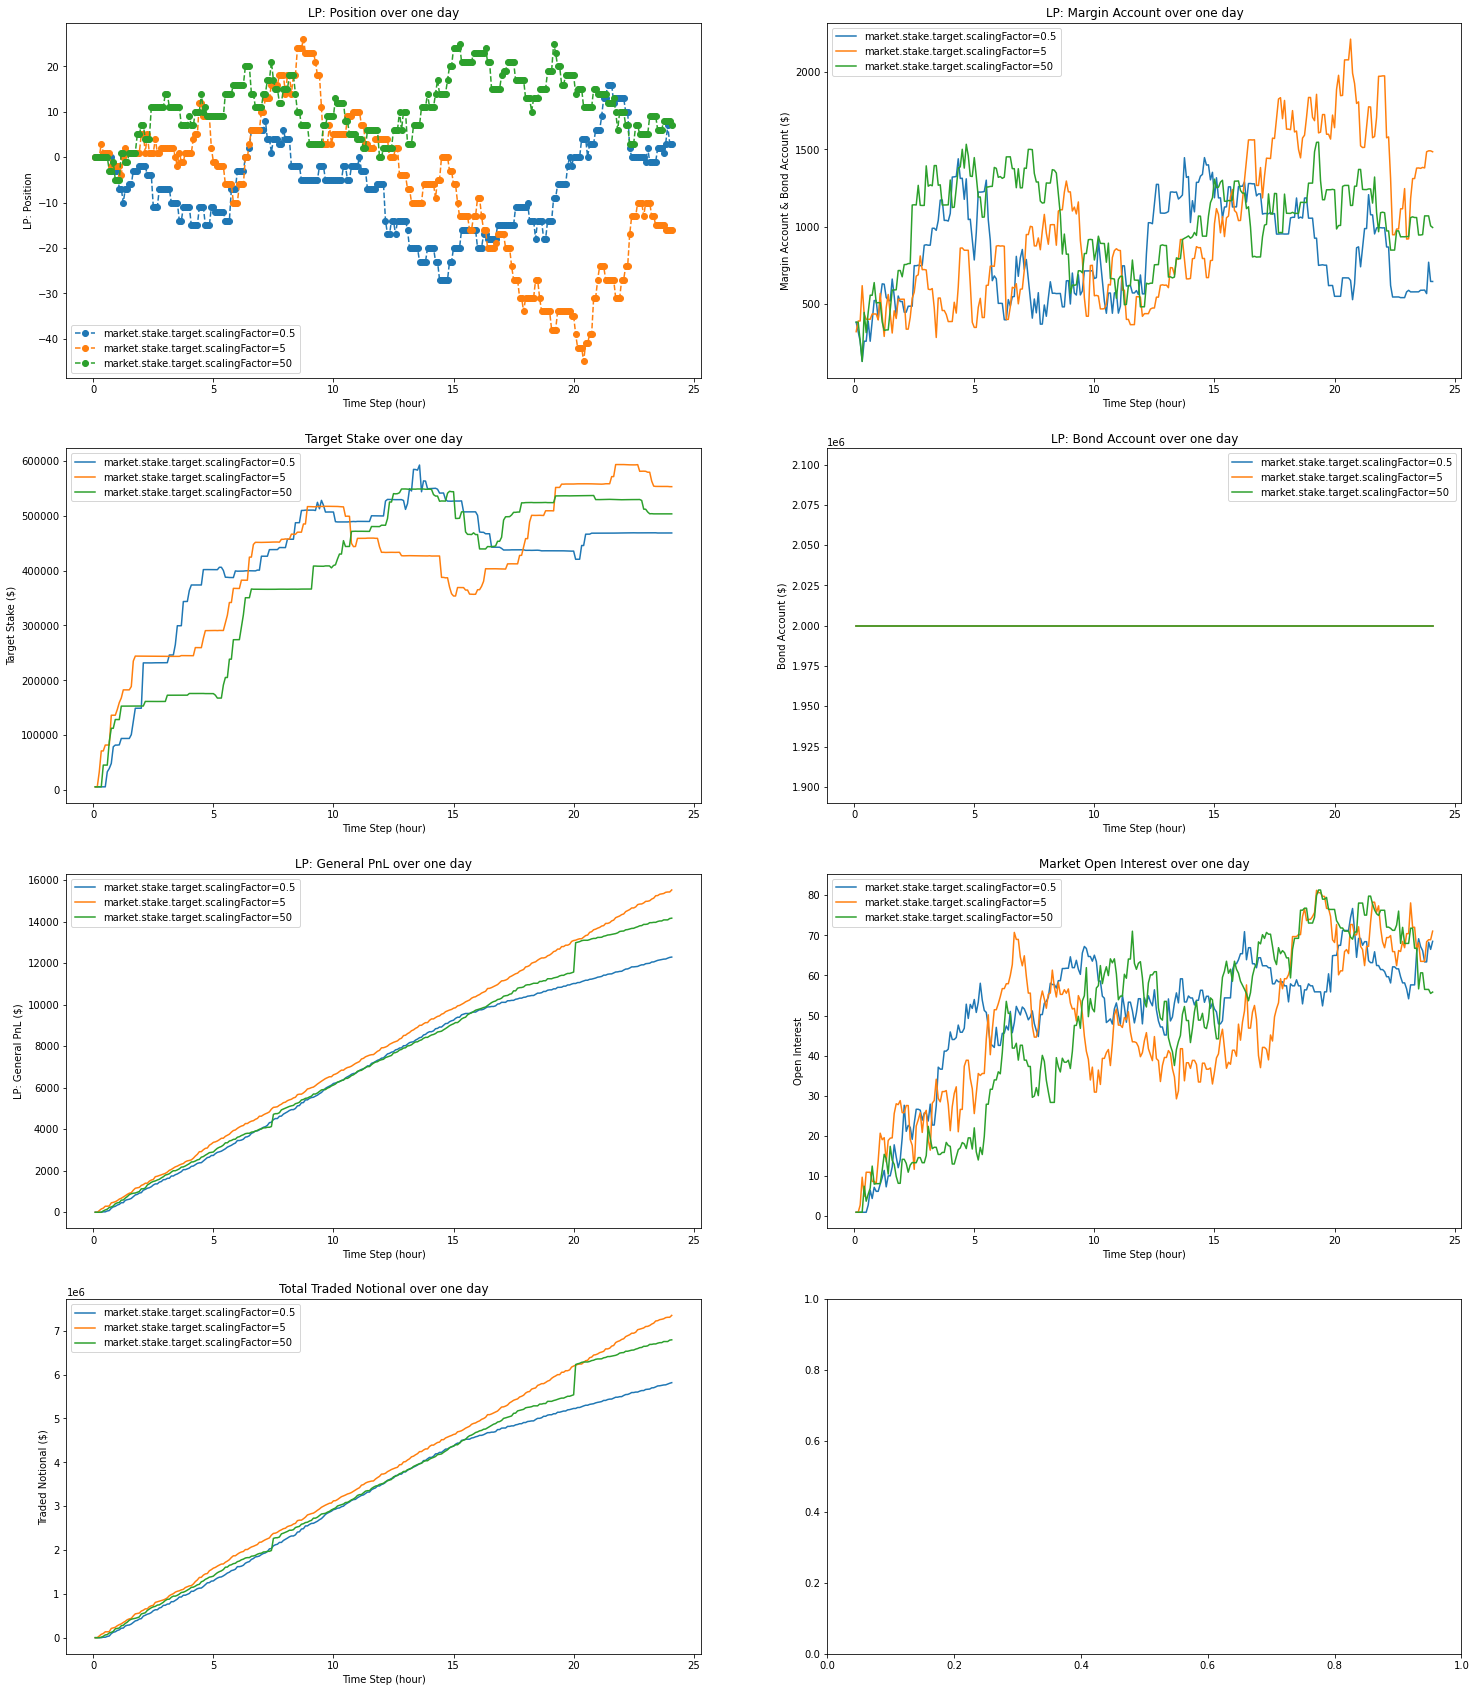

In [2]:
# Plot the optimal strategy
fig,ax = plt.subplots(4,2,figsize=(25,30))

# Since the interval of sim is 5 min
dt = 5 / 60

# Plot LP: Position over one day
for _ in range(num_of_paravalues):
    ax[0,0].plot(data_ave[_].index * dt,data[_][data[_]['Iteration'] == 0]['LP: Position'],'o--',label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
# ax[0,0].plot(ave_tau_1.index * dt,data_tau_1['LP: Position'],'o--',label="tauscaling=1")
# ax[0,0].plot(ave_tau_10.index * dt,data_tau_10['LP: Position'],'o--',label="tauscaling=10")
# ax[0,0].plot(ave_tau_100.index * dt,data_tau_100['LP: Position'],'o--',label="tauscaling=100")
ax[0,0].set_title('LP: Position over one day')
ax[0,0].set_xlabel("Time Step (hour)")
ax[0,0].set_ylabel("LP: Position")
ax[0,0].legend()

# Plot LP: Margin Account 
for _ in range(num_of_paravalues):
    ax[0,1].plot(data_ave[_].index * dt,data_ave[_]['LP: Margin Account'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[0,1].set_title('LP: Margin Account over one day')
ax[0,1].set_xlabel("Time Step (hour)")
ax[0,1].set_ylabel("Margin Account & Bond Account ($)")
ax[0,1].legend()

# Bond Account
for _ in range(num_of_paravalues):
    ax[1,1].plot(data_ave[_].index * dt,data_ave[_]['LP: Bond Account'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[1,1].set_title('LP: Bond Account over one day')
ax[1,1].set_xlabel("Time Step (hour)")
ax[1,1].set_ylabel("Bond Account ($)")
ax[1,1].legend()

# Plot target stake in market
for _ in range(num_of_paravalues):
    ax[1,0].plot(data_ave[_].index * dt,data_ave[_]['Target Stake'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[1,0].set_title('Target Stake over one day')
ax[1,0].set_xlabel("Time Step (hour)")
ax[1,0].set_ylabel("Target Stake ($)")
ax[1,0].legend()

# Plot LP: General PnL
for _ in range(num_of_paravalues):
    ax[2,0].plot(data_ave[_].index * dt,data_ave[_]['LP: GeneralPnl'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[2,0].set_title('LP: General PnL over one day')
ax[2,0].set_xlabel("Time Step (hour)")
ax[2,0].set_ylabel("LP: General PnL ($)")
ax[2,0].legend()

# Plot Market Open Interest
for _ in range(num_of_paravalues):
    ax[2,1].plot(data_ave[_].index * dt,data_ave[_]['Market Open Interest'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[2,1].set_title('Market Open Interest over one day')
ax[2,1].set_xlabel("Time Step (hour)")
ax[2,1].set_ylabel("Open Interest")
ax[2,1].legend()

# Plot Total Traded Notional
for _ in range(num_of_paravalues):
    ax[3,0].plot(data_ave[_].index * dt,data_ave[_]['Total Traded Notional'],label="{para}={value}".format(para = setting['parameter_tested'],value = setting['tested_values'][_]))
ax[3,0].set_title('Total Traded Notional over one day')
ax[3,0].set_xlabel("Time Step (hour)")
ax[3,0].set_ylabel("Traded Notional ($)")
ax[3,0].legend()

plt.show()

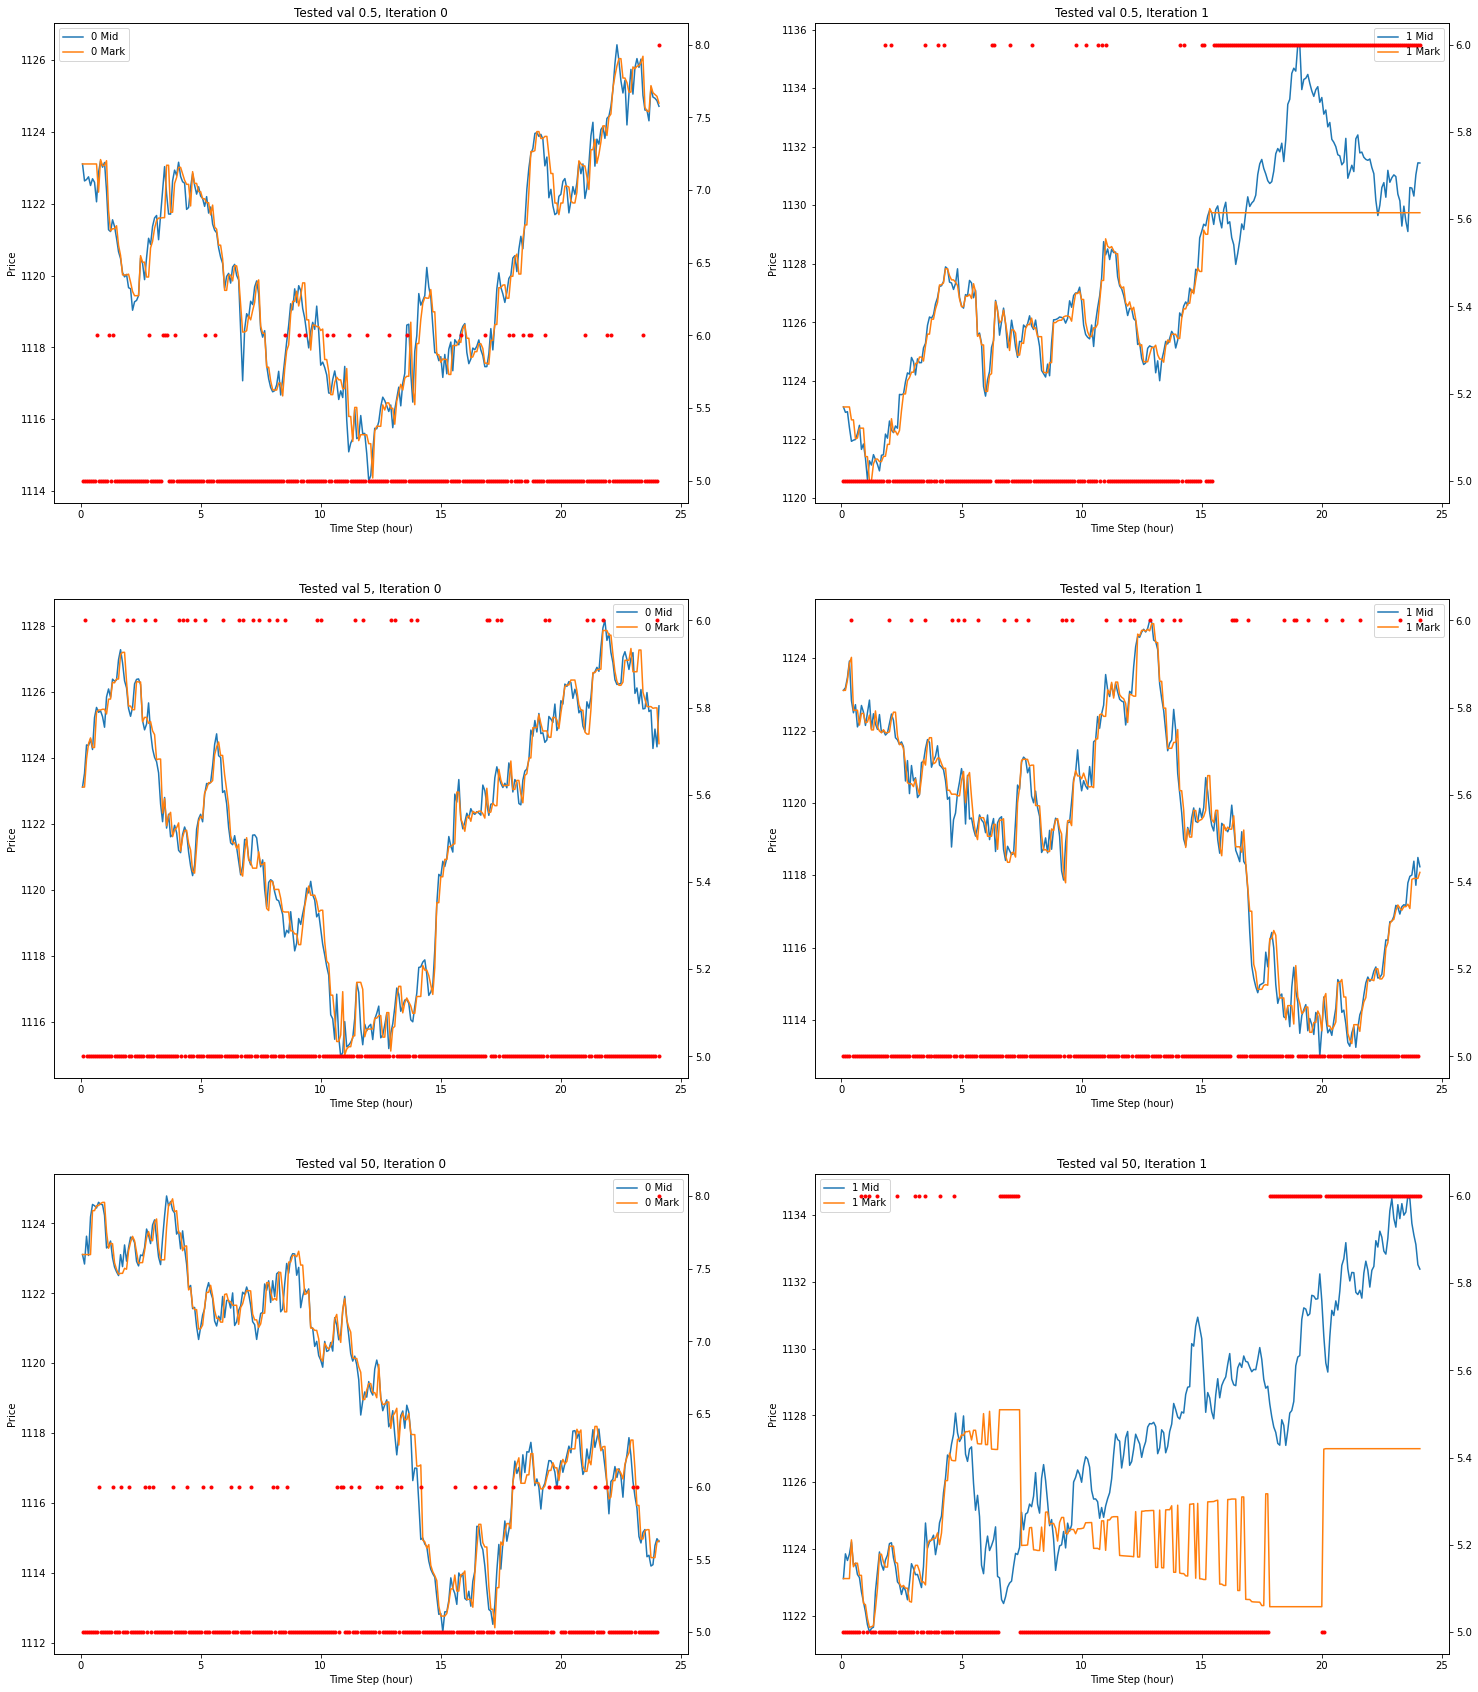

In [67]:
rows = len(setting['tested_values'])
cols = max(data[0]['Iteration'])+1
fig,ax = plt.subplots(rows,cols,figsize=(25,30))

for data_index in range(0,rows):
    for iter_num, iter_df in data[data_index].groupby('Iteration'):
        ax[data_index,iter_num].plot(data_ave[data_index].index * dt, iter_df['Midprice'], label=f"{iter_num} Mid")
        ax[data_index,iter_num].plot(data_ave[data_index].index * dt, iter_df['Markprice'], label=f"{iter_num} Mark")
        ax[data_index,iter_num].legend()
        ax[data_index,iter_num].set_title('Tested val ' + str(setting['tested_values'][data_index]) +', Iteration '+str(iter_num))
        ax[data_index,iter_num].set_xlabel("Time Step (hour)")
        ax[data_index,iter_num].set_ylabel("Price")
        
        ax2 = ax[data_index,iter_num].twinx()
        ax2.plot(data_ave[data_index].index * dt, iter_df['Market State'], '.', color='red', label=f"{iter_num} State")
